# Keypoint Detection

In [2]:
from tqdm import tqdm

import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
from ultralytics import YOLO

from SoccerNet.Downloader import SoccerNetDownloader

print(f'Torch CUDA availability: {torch.cuda.is_available()}')
print(f'Torch MPS availability: {torch.mps.is_available()}')

if torch.cuda.is_available():
    torch.device('cuda')
elif torch.mps.is_available():
    torch.device('mps')

soccernet_downloader = SoccerNetDownloader(LocalDirectory="../data/raw")

Torch CUDA availability: False
Torch MPS availability: True


/Users/sam/miniconda3/envs/ISC-Football/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
games = [
    'england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley',
]

for game in games:
    soccernet_downloader.downloadGame(
        game=game,
        files=['Frames-v3.zip', 'Labels-v3.json']
    )

    os.system(f'unzip "../data/raw/{game}/Frames-v3.zip" -d "../data/raw/{game}/frames"')

../data/raw/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/Frames-v3.zip already exists
../data/raw/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/Labels-v3.json already exists
Archive:  ../data/raw/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/Frames-v3.zip
  inflating: ../data/raw/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/frames/10_0.png  
  inflating: ../data/raw/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/frames/1_3.png  
  inflating: ../data/raw/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/frames/6_1.png  
  inflating: ../data/raw/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/frames/19_1.png  
  inflating: ../data/raw/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/frames/15.png  
  inflating: ../data/raw/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/frames/1.png  
  inflating: ../data/raw/england_epl/2014-2015/2015-02-21 - 18-

Image resolution: (1080, 1920, 3)


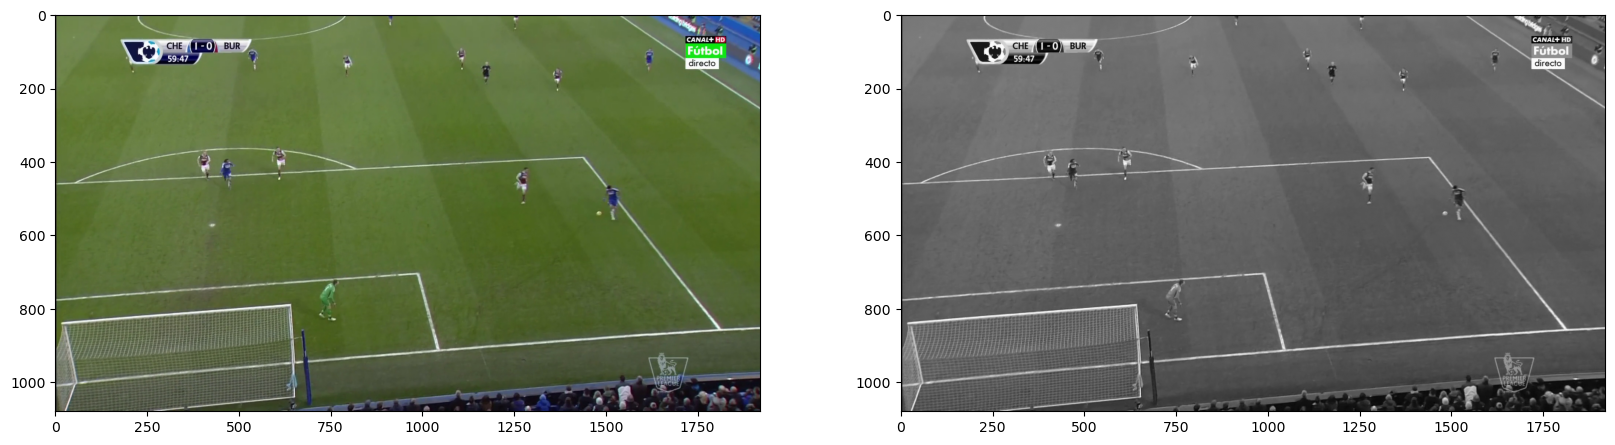

In [5]:
filename = '../data/raw/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/frames/16.png'
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
axes[0].imshow(img)
axes[1].imshow(img_gray, cmap='gray')
print(f'Image resolution: {img.shape}')

## Harris Corner detection

Image resolution: (1080, 1920, 3)


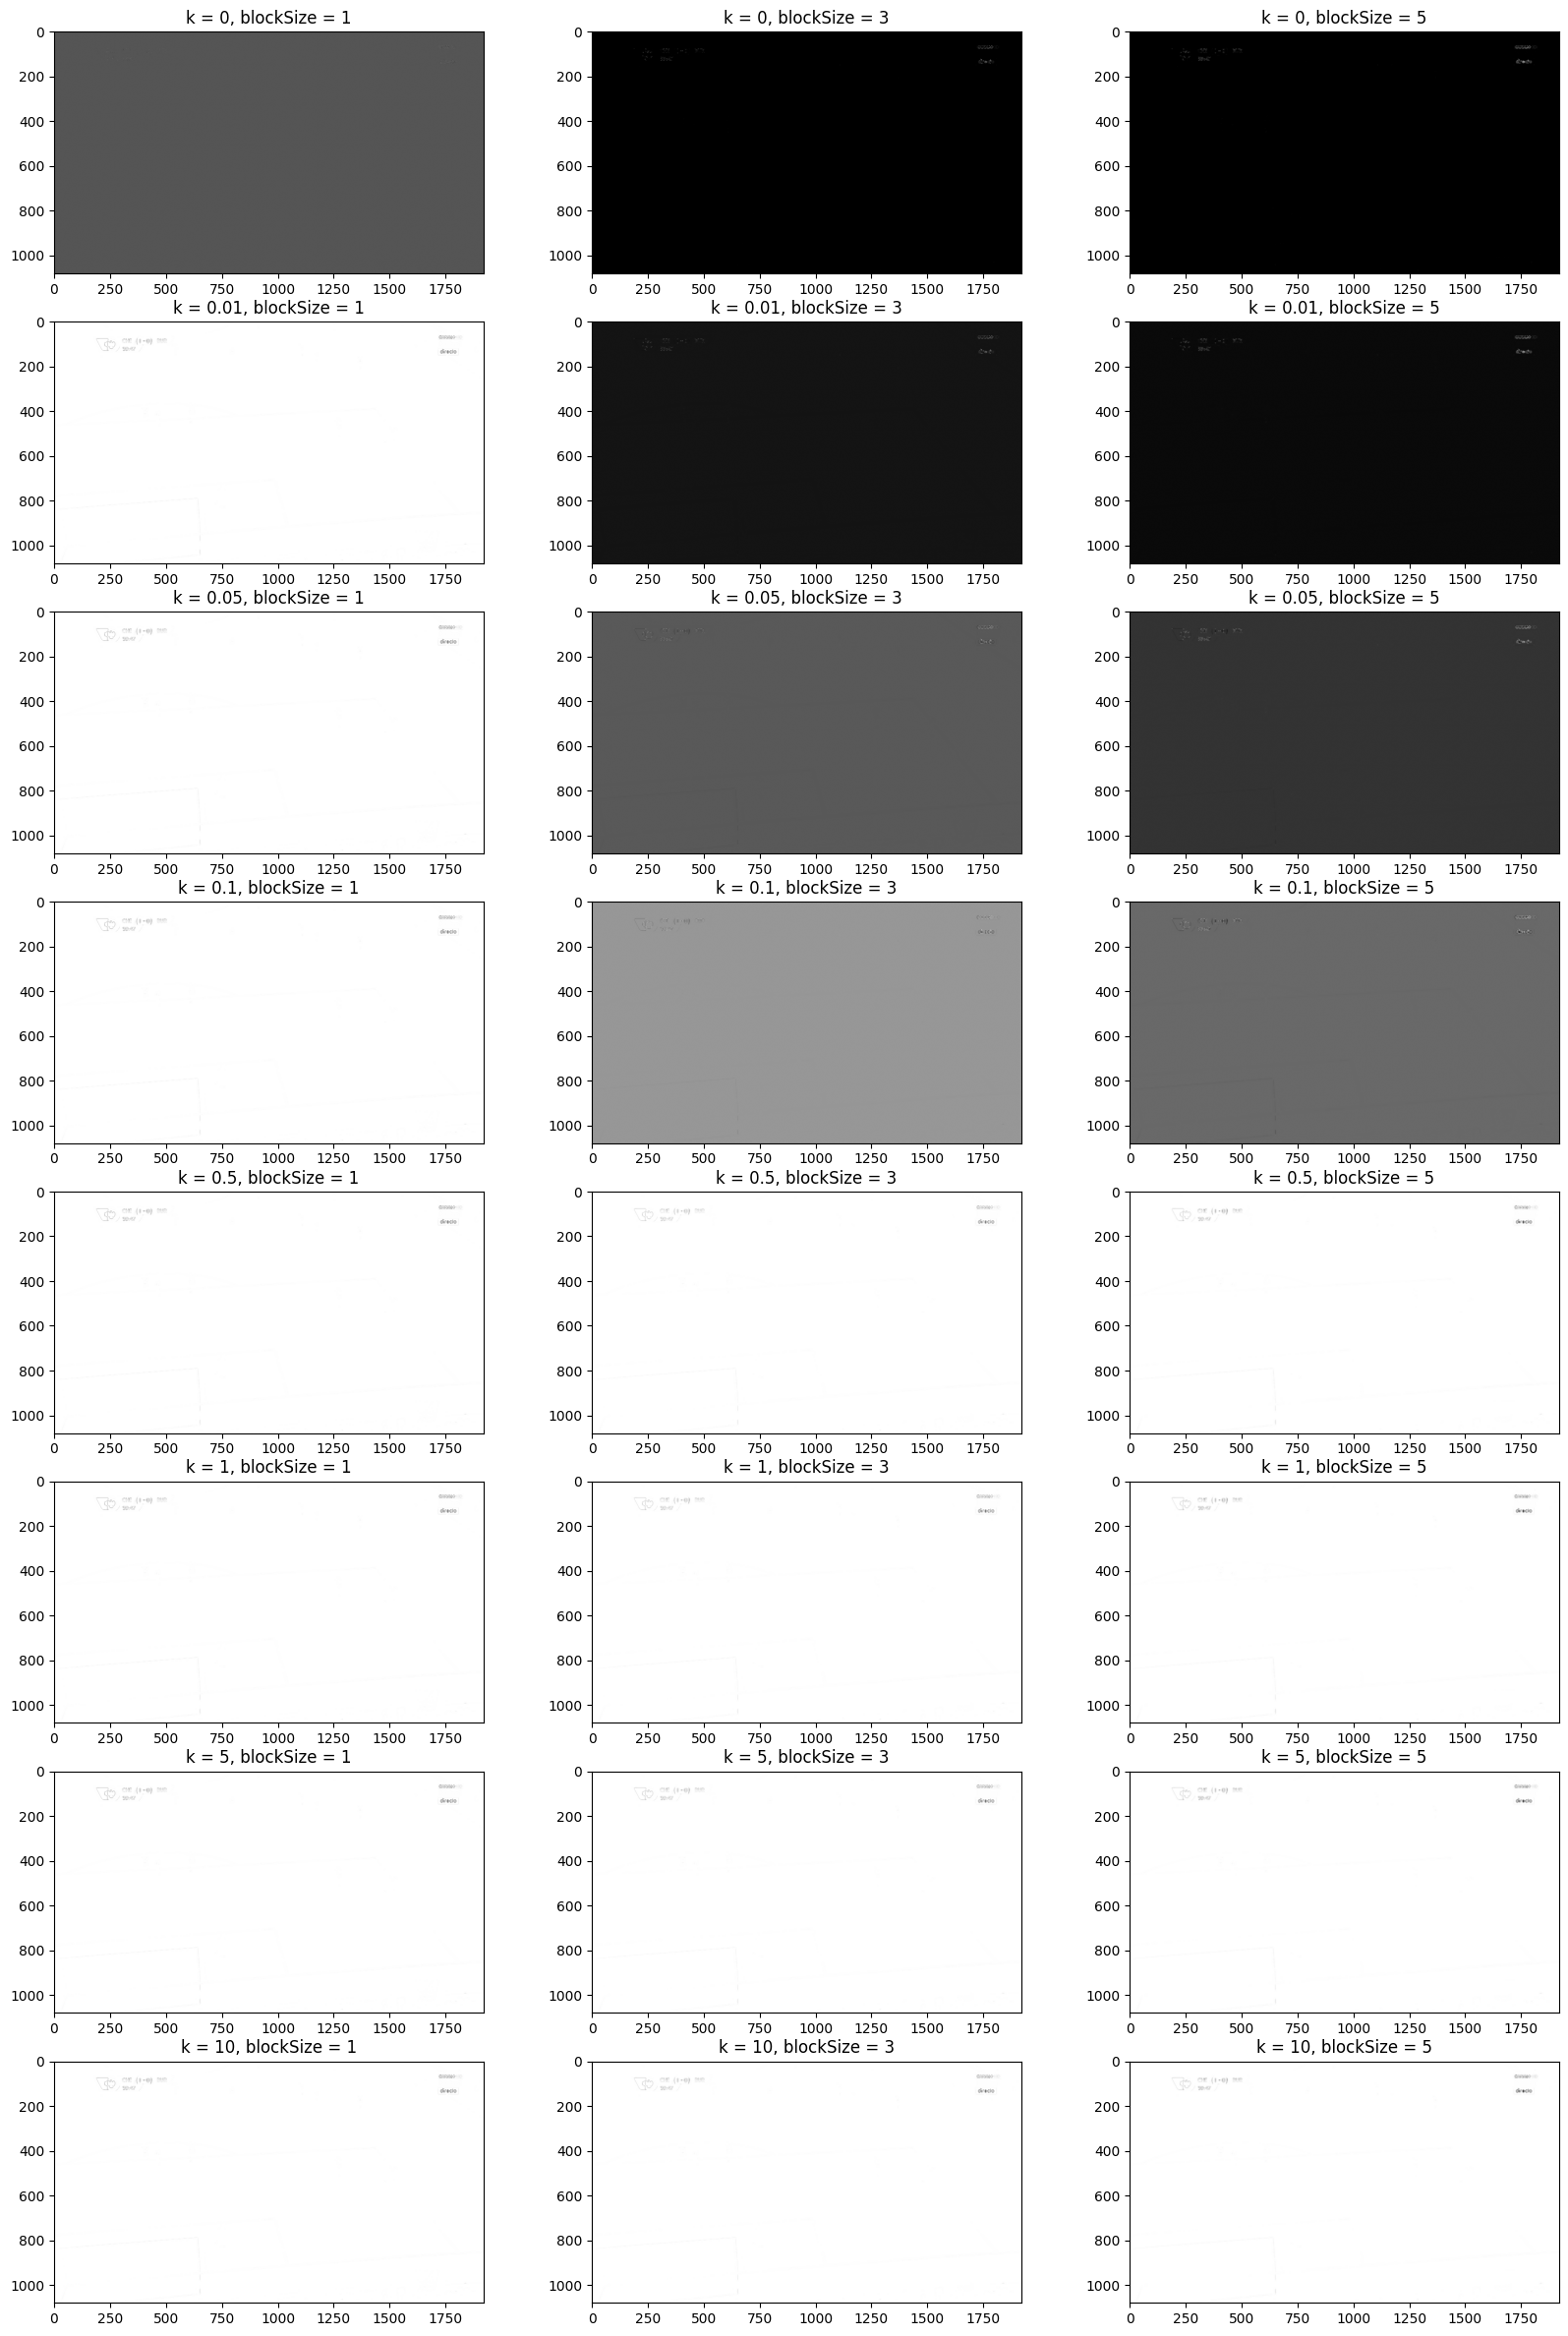

In [100]:
ks = [0, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
blockSizes = [1, 3, 5]

fig, axes = plt.subplots(ncols=len(blockSizes), nrows=len(ks), figsize=(20, 30))
for x in range(len(ks)):
    for y in range(len(blockSizes)):
        k, blockSize = ks[x], blockSizes[y]
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        dst = cv2.cornerHarris(img_gray, blockSize=blockSize, ksize=3, k=k)

        axes[x, y].imshow(dst, cmap='gray')
        axes[x, y].title.set_text(f'k = {k}, blockSize = {blockSize}')

print(f'Image resolution: {img.shape}')

## YOLO base model (for ball detection)

In [3]:
model = YOLO('../weights/benchmark/yolo-sn-ball-opt.pt')
model.names

{0: 'ball'}


0: 736x1280 1 ball, 2174.2ms
Speed: 9.0ms preprocess, 2174.2ms inference, 9.5ms postprocess per image at shape (1, 3, 736, 1280)
1474 534 1488 549


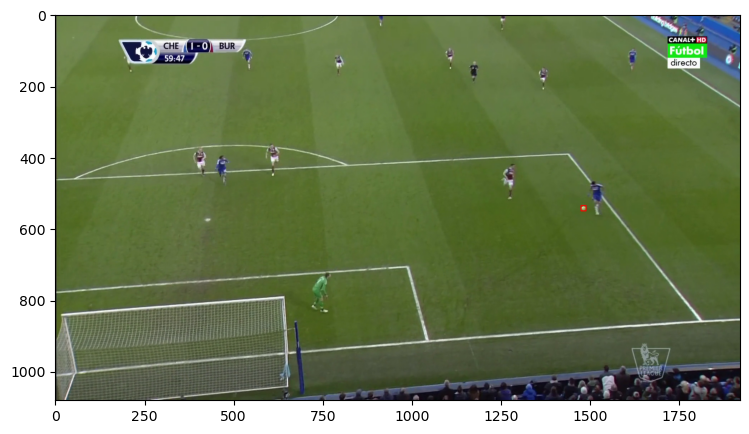

In [6]:
res = model(img)
x1, y1, x2, y2 = res[0].boxes.xyxy.numpy().astype(int).reshape(4)
print(x1, y1, x2, y2)

cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)
plt.figure(figsize=(10, 5))
plt.imshow(img)

## Extending YOLO for multiple classes